In [73]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
import random
import pandas as pd


### Heston Model SDE
The heston model is defined by a system of SDEs, to describe the movement of asset prices, where an
asset’s price and volatility follow random, Brownian motion processes (this is under real world measure $\mathbb{P}$):

$\large dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^\mathbb{P}_{S,t}$
    
$\large dv_t = \kappa(\theta - v_t)dt +\sigma \sqrt{v_t} dW^\mathbb{P}_{v,t}$

Where the variables are:
- $\sigma$ volatility of volatility
- $\theta$ long-term price variance
- $\kappa$ rate of reversion to the long-term price variance
- $dW^\mathbb{P}_{S,t}$ Brownian motion of asset price
- $dW^\mathbb{P}_{v,t}$ Brownian motion of asset's price variance
- $\rho^\mathbb{P}$ correlation between $dW^\mathbb{P}_{S,t}$ and $dW^\mathbb{P}_{v,t}$

Dynamics under risk-neutral measure $\mathbb{Q}$:

$\large dS_t = r S_t dt + \sqrt{v_t}S_t dW^\mathbb{Q}_{S,t}$
    
$\large dv_t = \kappa^\mathbb{Q}(\theta^\mathbb{Q} - v_t)dt +\sigma^\mathbb{Q} \sqrt{v_t} dW^\mathbb{Q}_{v,t}$

In [107]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations

    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    
    x = []
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    random.seed(420)
    np.random.seed(420)
    x = np.random.randn(252, 1)
    print(x)
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0) + 0.01 * x[i-1] ** 2

    return S, v

In [108]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 1                  # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

theta, v0

(0.04000000000000001, 0.0625)

In [109]:
rho_p = 0.98
rho_n = -0.98
random.seed(420)
np.random.seed(420)
S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
#S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

[[-0.48539085]
 [-1.90515385]
 [-0.5262218 ]
 [-0.31354602]
 [ 0.33070649]
 [ 0.93853725]
 [-0.56821116]
 [-0.19377527]
 [ 1.31280484]
 [ 1.681251  ]
 [-0.76813595]
 [-0.76311794]
 [-0.45737545]
 [-2.15541652]
 [ 0.51516947]
 [ 0.37920962]
 [-0.69993372]
 [ 0.7089239 ]
 [-0.34798538]
 [ 1.54588781]
 [ 0.54680904]
 [-1.284877  ]
 [-1.73820287]
 [-0.51482514]
 [ 0.37004361]
 [-1.71219704]
 [ 1.32854527]
 [ 0.85180451]
 [-1.17732503]
 [ 1.12722017]
 [ 0.49599207]
 [ 1.33015894]
 [ 0.64812082]
 [-1.99832609]
 [ 0.34026654]
 [ 0.30297731]
 [-1.01807988]
 [ 0.36972476]
 [-0.99125932]
 [ 1.17140585]
 [ 2.28693771]
 [ 1.10545818]
 [-0.56546254]
 [ 0.70761329]
 [ 0.16505748]
 [-0.73070227]
 [-0.52965621]
 [-0.59603401]
 [-0.65072001]
 [ 0.01757337]
 [-0.86330093]
 [-0.85526903]
 [ 0.06352153]
 [-2.24336739]
 [ 0.2619215 ]
 [-1.12931946]
 [-0.56196398]
 [-1.03443857]
 [-1.34825025]
 [-1.86763833]
 [ 1.56425096]
 [-1.74863733]
 [ 1.3871611 ]
 [ 0.0315956 ]
 [-0.55068869]
 [ 0.74654001]
 [-1.23866

In [110]:
len(S_p)

253

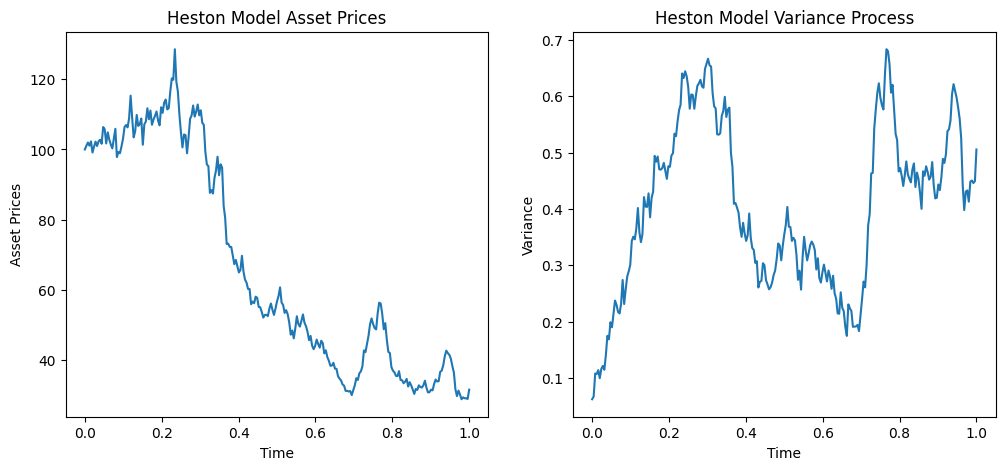

In [111]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

In [112]:
from Garch import GARCH
from arch import arch_model


In [113]:
np.mean(S_p)

66.65744841457419

In [114]:
prices_df = pd.DataFrame(S_p, columns = ['Prices'])


In [115]:
prices_df['returns'] = prices_df['Prices'].pct_change()
prices_df['log_returns'] = np.log(prices_df['Prices'] /prices_df['Prices'].shift(1))

In [116]:
prices_df = prices_df[1:]

In [117]:
prices_df

,Prices,returns,log_returns
1,101.061753,0.010618,0.010562
2,101.977255,0.009059,0.009018
3,101.074066,-0.008857,-0.008896
4,102.286712,0.011998,0.011926
5,99.112675,-0.031031,-0.031522
...,...,...,...
248,29.405478,0.018074,0.017913
249,29.143106,-0.008923,-0.008963
250,29.158024,0.000512,0.000512
251,28.948963,-0.007170,-0.007196


In [118]:
# Fit using ARCH library, without exogeneous
model = arch_model(100*prices_df['log_returns'], vol='GARCH', mean='zero', p=1, q=1)
garch_fit = model.fit(disp='off')

garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -703.292
Distribution:                  Normal   AIC:                           1412.58
Method:            Maximum Likelihood   BIC:                           1423.17
                                        No. Observations:                  252
Date:                Sat, Mar 01 2025   Df Residuals:                      252
Time:                        17:26:29   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.2064      0.113      1.834  6.659e-02   [-1.412e-02,  0.427]
alpha[1]       0.0000  2.183e-02      0.000      1.000 [-4.279e-02,4.279e-02]
beta[1]        0.9908  2.203e-02     44.979      0.000      [  0.948,  1.034]
=============================================================================

Covariance estimator: robust
"""

In [119]:
random.seed(420)
np.random.seed(420)
exo = np.random.randn(252, 1)

In [124]:
x

NameError: name 'x' is not defined

In [127]:
garch_with_sentiment = GARCH(p=1, q=1, z=1, verbose=True)
garch_with_sentiment.train(100*prices_df['log_returns'], x = 0.001 * exo)

garch_with_sentiment.summary()

Optimising...
Optimising finished in 0.739s
{'omega': 0.5641374506753284, 'alpha': 0.41773179070503974, 'beta': 0.5822570491919089, 'gamma': array([[0.50000028]])}


/Users/junwei/Desktop/FYP Code/sentiment-analysis-volatility-forecasting-1/notebooks/Garch.py:468: RuntimeWarning: invalid value encountered in sqrt
  diagnosis_df = pd.DataFrame(data={'coef': coef, 'std err': np.sqrt(info_mat_inv)}, index=index)


,coef,std err,t,P>|t|
omega,0.564137,0.455523,1.238440e+00,0.108362
alpha,0.417732,NaN,NaN,NaN
beta,0.582257,NaN,NaN,NaN
gamma[0],0.500000,550473.780194,9.083090e-07,0.500000


In [128]:
info_matrix = garch_with_sentiment.information_matrix
np.linalg.inv(info_matrix).diagonal()

array([ 2.07500754e-01, -2.91105356e-05, -2.91238167e-05,  3.03021383e+11])

In [122]:
prices_df

,Prices,returns,log_returns
1,101.061753,0.010618,0.010562
2,101.977255,0.009059,0.009018
3,101.074066,-0.008857,-0.008896
4,102.286712,0.011998,0.011926
5,99.112675,-0.031031,-0.031522
...,...,...,...
248,29.405478,0.018074,0.017913
249,29.143106,-0.008923,-0.008963
250,29.158024,0.000512,0.000512
251,28.948963,-0.007170,-0.007196


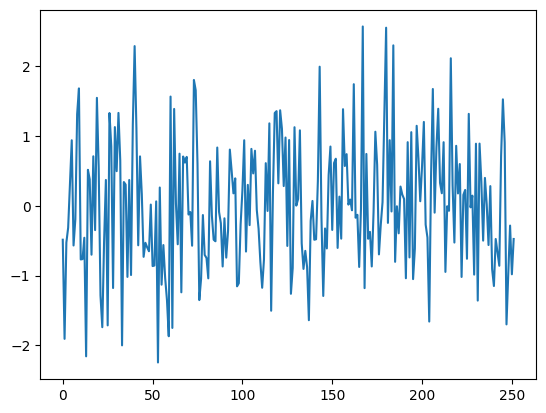

In [125]:
plt.plot(exo)